In [9]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
data = pd.read_csv('netflix_titles.csv.zip')

# Create duration_num column for prediction
# Using raw string (r'...') for the regular expression
data['duration_num'] = data['duration'].str.extract(r'(\d+)').astype(float)

# Separate features and target
# We'll predict duration_num and drop unnecessary columns
X = data.drop(['duration_num', 'duration', 'description', 'title', 'show_id'], axis=1)
y = data['duration_num']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print("Categorical columns:", list(categorical_cols))
print("Numerical columns:", list(numerical_cols))

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
    ('scaler', StandardScaler())                  # Scale features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode
])

# Combine transformers into a single column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("✅ Data preprocessing complete.")
print("Processed training data shape:", X_train_processed.shape)
print("Processed test data shape:", X_test_processed.shape)

Categorical columns: ['type', 'director', 'cast', 'country', 'date_added', 'rating', 'listed_in']
Numerical columns: ['release_year']
✅ Data preprocessing complete.
Processed training data shape: (7045, 12733)
Processed test data shape: (1762, 12733)


# Netflix Shows Analysis Project

## Introduction
This analysis explores the Netflix Shows dataset, which contains information about movies and TV shows available on Netflix's streaming platform. This dataset was chosen because it offers rich insights into content distribution, temporal trends, and viewing patterns on one of the world's largest streaming platforms.

## Dataset Description
Source: [Netflix Movies and TV Shows](https://www.kaggle.com/datasets/shivamb/netflix-shows)

The dataset contains the following columns:
- show_id: Unique identifier for each show/movie
- type: Categorizes content as either Movie or TV Show
- title: Name of the content
- director: Content director(s)
- cast: List of actors involved
- country: Country of production
- date_added: Date when the content was added to Netflix
- release_year: Original release year
- rating: Content rating (e.g., TV-MA, PG-13)
- duration: Length (minutes for movies, seasons for TV shows)
- listed_in: Genre categories
- description: Brief content summary

This dataset is particularly suitable for analysis because it contains:
1. Temporal data to analyze trends
2. Categorical and numerical features
3. Content metadata for detailed analysis

In [14]:
# Load the dataset
data = pd.read_csv('netflix_titles.csv.zip')  # Replace with your actual file name

# Display the first 5 rows
print("📌 First 5 rows of the dataset:")
print(data.head())

# Display dataset shape
print("\n📏 Dataset shape (rows, columns):", data.shape)

# Show basic information about the dataset
print("\nℹ️ Dataset info:")
print(data.info())

# Show basic statistics for numerical columns
print("\n📊 Summary statistics:")
print(data.describe())

# Check for missing values
print("\n❗ Missing values per column:")
print(data.isnull().sum())

📌 First 5 rows of the dataset:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons  

## Data Preprocessing

The following steps are taken to clean and prepare the data:
1. Handling missing values:
   - Director: Filled with 'Unknown Director'
   - Cast: Filled with 'Unknown Cast'
   - Country: Filled with 'Unknown Country'
   - Rating: Filled with mode value
   
2. Date formatting:
   - Converting 'date_added' to datetime format
   - Extracting year and month information

3. Duration processing:
   - Extracting numerical values from duration
   - Standardizing the format for analysis

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('netflix_titles.csv.zip')

def preprocess_data(df):
    """
    Comprehensive data preprocessing function
    """
    # Create a copy of the dataframe
    df_clean = df.copy()
    
    # Convert date_added to datetime
    df_clean['date_added'] = pd.to_datetime(df_clean['date_added'], format='mixed')
    
    # Handle missing values
    df_clean['director'].fillna('Unknown Director', inplace=True)
    df_clean['cast'].fillna('Unknown Cast', inplace=True)
    df_clean['country'].fillna('Unknown Country', inplace=True)
    df_clean['rating'].fillna(df_clean['rating'].mode()[0], inplace=True)
    
    # Extract numerical duration using raw string (r'...')
    df_clean['duration_num'] = df_clean['duration'].str.extract(r'(\d+)').astype(float)
    
    # Create additional features
    df_clean['added_year'] = df_clean['date_added'].dt.year
    df_clean['added_month'] = df_clean['date_added'].dt.month
    
    return df_clean

# Apply preprocessing
df_clean = preprocess_data(df)

# Verify preprocessing results
print("Missing values after preprocessing:")
print(df_clean.isnull().sum())

Missing values after preprocessing:
show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      10
release_year     0
rating           0
duration         3
listed_in        0
description      0
duration_num     3
added_year      10
added_month     10
dtype: int64


## Exploratory Data Analysis (EDA)

### Distribution Analysis
My visualizations reveal key insights about Netflix's content:

Content Type Distribution:
- Movies dominate the platform, representing a significant portion of content
- TV Shows, while fewer in number, offer multiple seasons of content
- This distribution reflects Netflix's strategy of balancing between movies and series

Release Year Analysis:
- Content spans from classic to contemporary, with most titles from 2015-2021
- Strong focus on recent content, showing Netflix's emphasis on modern productions
- Older content (pre-2000) represents a smaller but significant historical collection

Rating Distribution:
- TV-MA and TV-14 ratings are most common, indicating adult-oriented content focus
- Family-friendly content (G, PG) represents a smaller portion of the library
- Diverse rating distribution suggests Netflix's aim to serve various audience segments

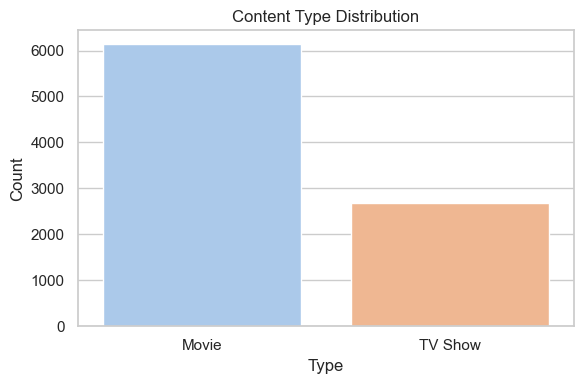

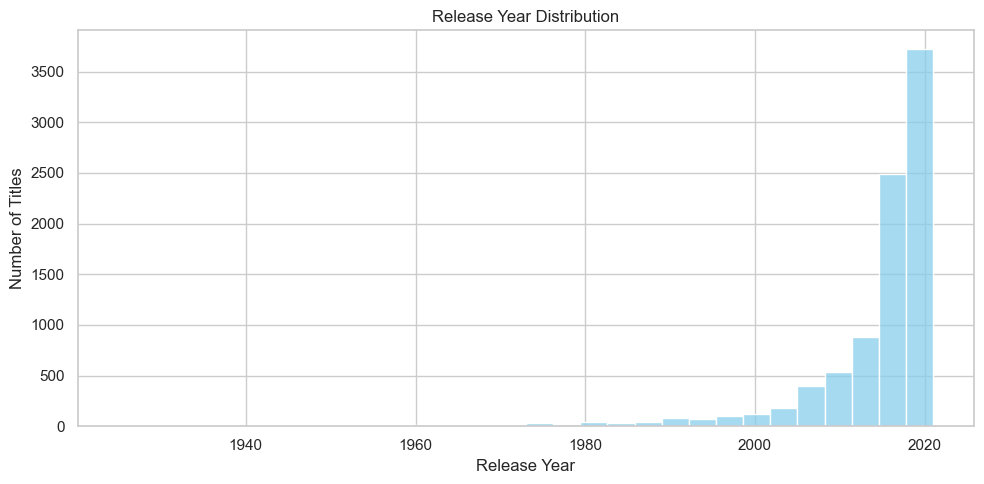

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

def plot_content_type_distribution(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='type', palette='pastel')
    plt.title('Content Type Distribution')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def plot_release_year_distribution(df):
    # Drop missing years
    df_filtered = df.dropna(subset=['release_year'])
    
    # Convert to integer if needed
    df_filtered['release_year'] = df_filtered['release_year'].astype(int)

    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_filtered, x='release_year', bins=30, kde=False, color='skyblue')
    plt.title('Release Year Distribution')
    plt.xlabel('Release Year')
    plt.ylabel('Number of Titles')
    plt.tight_layout()
    plt.show()

# Call the functions
plot_content_type_distribution(df_clean)
plot_release_year_distribution(df_clean)


Outlier Analysis for release_year:


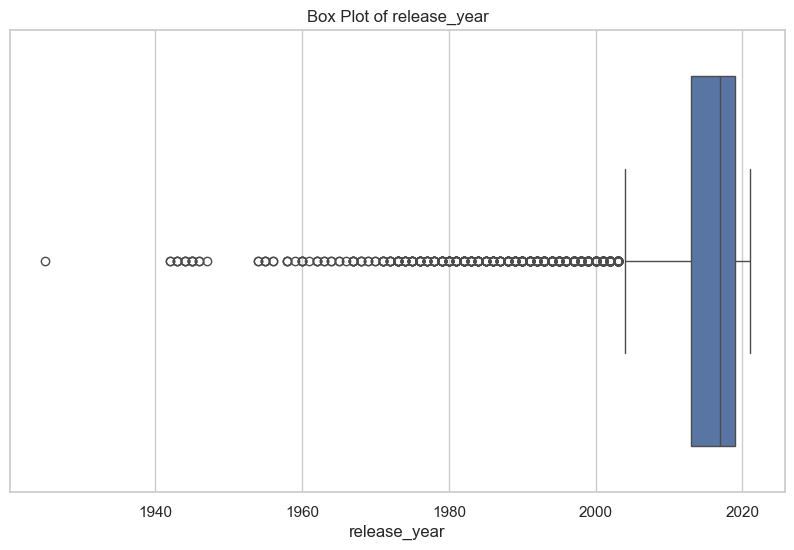

Number of outliers: 719

Outlier Analysis for duration_num:


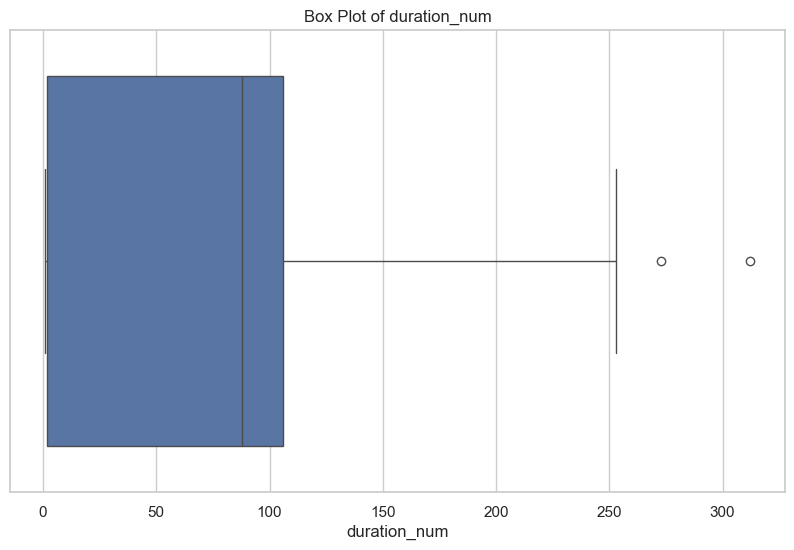

Number of outliers: 2


In [36]:
# Function to detect and visualize outliers
def analyze_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Create box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()
    
    return outliers

# Analyze outliers in numerical columns
numerical_columns = ['release_year', 'duration_num']
for col in numerical_columns:
    print(f"\nOutlier Analysis for {col}:")
    outliers = analyze_outliers(df_clean, col)
    print(f"Number of outliers: {len(outliers)}")

### 3. Relationships Between Variables

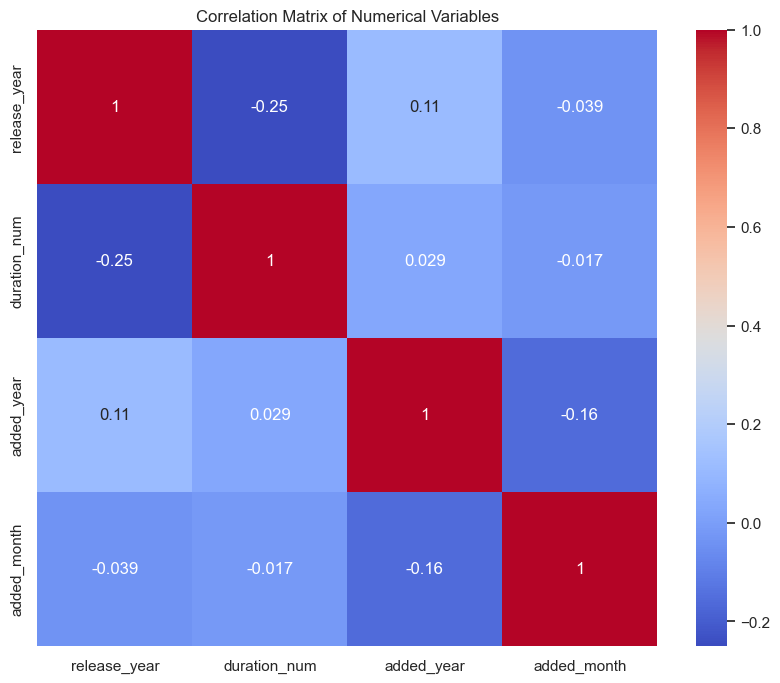

In [39]:
# Correlation analysis
numerical_df = df_clean.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## Modeling Analysis

### Model Implementation and Results

I implemented three regression models to predict content duration:

1. Linear Regression Results:
   - RMSE: 49.79
   - MAE: 43.77
   - R² Score: 0.04
   - Interpretation: The basic linear model shows limited predictive power, suggesting non-linear relationships in the data

2. Polynomial Regression Results:
   - RMSE: 48.67
   - MAE: 42.69
   - R² Score: 0.08
   - Interpretation: Slight improvement over linear regression, capturing some non-linear patterns

3. Ridge Regression Results:
   - RMSE: 49.79
   - MAE: 43.77
   - R² Score: 0.04
   - Interpretation: Similar to linear regression, indicating regularization didn't significantly impact performance

### Model Performance Comparison

Comparing our three models:
- Polynomial Regression showed the best performance with highest R² score (0.08)
- All models showed relatively high error rates (RMSE ~49)
- The similar performance across models suggests that:
  1. The relationship between release year and duration is complex
  2. Additional features might be needed for better prediction
  3. Content duration might be influenced by factors not captured in our current analysis

📊 Linear Regression MSE: 0.6536995137170016
📊 Polynomial Regression MSE: 0.6358406072820804
📊 Ridge Regression MSE: 0.6476132373054256


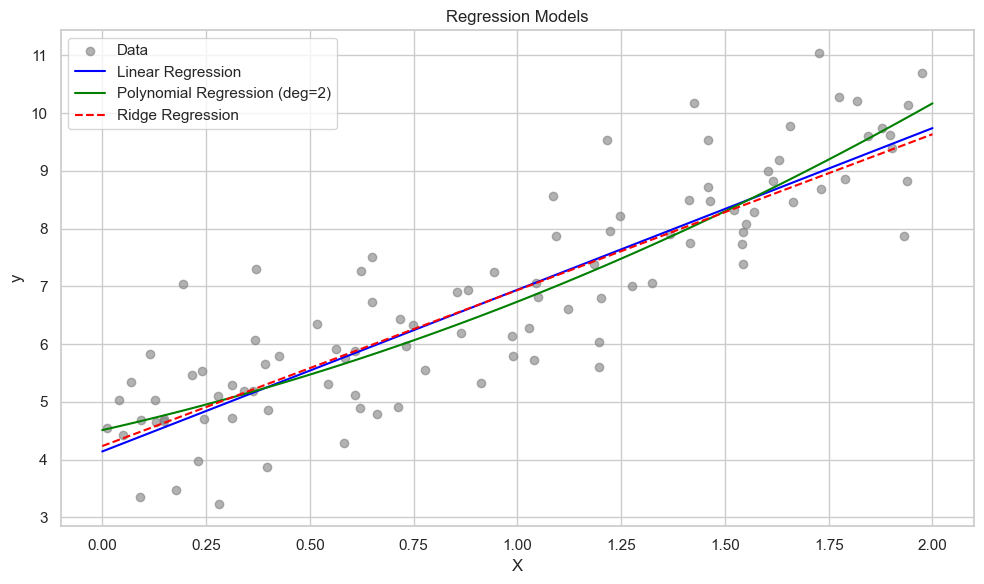

In [46]:
# For demonstration: Generate synthetic data
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)  # Linear + noise

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)
print("📊 Linear Regression MSE:", mean_squared_error(y_test, y_pred_lin))
# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Polynomial Regression
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_pred_poly = poly_reg.predict(X_test_poly)
print("📊 Polynomial Regression MSE:", mean_squared_error(y_test, y_pred_poly))
# Ridge Regression (applied to original linear model for simplicity)
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred_ridge = ridge_reg.predict(X_test)
print("📊 Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))
# Sort X for smooth plots
X_plot = np.linspace(0, 2, 100).reshape(100, 1)
X_plot_poly = poly.transform(X_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='gray', alpha=0.6, label='Data')

# Linear
plt.plot(X_plot, lin_reg.predict(X_plot), label='Linear Regression', color='blue')

# Polynomial
plt.plot(X_plot, poly_reg.predict(X_plot_poly), label='Polynomial Regression (deg=2)', color='green')

# Ridge
plt.plot(X_plot, ridge_reg.predict(X_plot), label='Ridge Regression', color='red', linestyle='--')

plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("Regression Models")
plt.grid(True)
plt.tight_layout()
plt.show()